<a href="https://colab.research.google.com/github/danaderp/SecureReqNet/blob/master/alpha_securereqnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alpha-SecureReqNet

In [2]:
#danaderp May6'19
#Prediction For Main Issues Data Set 
#alpha-SecureReqNet

In [3]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [ ]:
import nltk
nltk.download('stopwords')

In [5]:
#Importing Neural Dependencies
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.1.0


In [ ]:
#Visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [11]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [12]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [13]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [14]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [15]:
sys.meta_path.append(NotebookFinder())

In [18]:
from data.read_data import Dynamic_Dataset
from data.read_data import Processing_Dataset

### Loading word embeddings from previous compression

In [19]:
path = "data/augmented_dataset/" #Place here the dataset you want to process
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [20]:
dataset = Dynamic_Dataset(ground_truth, path)
test, train = process_unit.get_test_and_training(ground_truth)
print(len(test),len(train))
print(test[0],train[0])

In [21]:
#Preprocesing Corpora
# embeddings = Embeddings
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [ ]:
# Rewrite cell above
import pandas as pd
embed_path = 'data/word_embeddings-embed_size_100-epochs_100.csv'
df = pd.read_csv(embed_path)
cols = df.columns[1:]

print(len(cols))
print(cols)
df.reset_index()
embeddings_dict = {}
for i in range(len(cols)):
    embeddings_dict[cols[i]] = list(df.iloc[:,i+1])


In [27]:
corpora_train_mod = []

y_train=[]
for row in pre_corpora_train:
    corpora_train_mod.append(row[1])
    y_train.append(row[0][1])
    
np.asarray(y_train)
corpora_test_mod=[]
y_test=[]
for row in pre_corpora_test:
    corpora_test_mod.append(row[1])
    y_test.append(row[0][1])
    
np.asarray(y_test)

array(['1', '0', '1', ..., '0', '1', '0'], dtype='<U1')

In [29]:
import re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thutran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/thutran/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/thutran/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
num_features=100

def nomalizer(sent):
    only_letters=re.sub("[^a-zA-Z]", " ", sent)
    tokens=nltk.word_tokenize(only_letters)[2:]
    lower_case=[l.lower() for l in tokens]
    stop_words = set(stopwords.words('english'))
    wordnet_lemmatizer=WordNetLemmatizer()
    filtered_result=list(filter(lambda l: l not in stop_words, lower_case))
    lemmas=[wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

# Generate a sentence vector by averaging words embeddings in a sentence
def generate_sentence_vec(sentence, embeddings_dict, num_features):
    sentence_vec=np.zeros(num_features,dtype="float32")
    num_words = 0
    
    embeddings_set=set(embeddings_dict.keys())
    
    for word in sentence:
        if word in embeddings_set:
            num_words+=1
            sentence_vec=np.add(sentence_vec, embeddings_dict[word])
    
    sentence_vec=np.divide(sentence_vec,num_words)
    #print(sentence_vec)
    return sentence_vec

# Generate all senteneces vectors
def generate_average_sentences_vec(sentences,embeddings_dict,num_features):
    count=0
    total_sent=len(sentences)
    sentences_vec=np.zeros((len(sentences),num_features),dtype="float32")
    
    for sentence in sentences:
        if count % 1000 == 0:
            print("Sentences {} of {}".format(count,total_sent))

        sentences_vec[count] = generate_sentence_vec(sentence, embeddings_dict, num_features)
        count+=1

    return sentences_vec

def get_sentence_vectors(raw_data):
    data = []
    print(len(raw_data))
    print("---- Nomalizing ----")
    for sent in raw_data:
        data.append(nomalizer(sent))
    
    print(len(data))
    X=generate_average_sentences_vec(data, embeddings_dict, num_features)
    return X

X_train_data = get_sentence_vectors(corpora_train_mod)
X_test_data=get_sentence_vectors(corpora_test_mod)

In [31]:
corpora_train = X_train_data
corpora_test = X_test_data

In [33]:
# Try with SVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

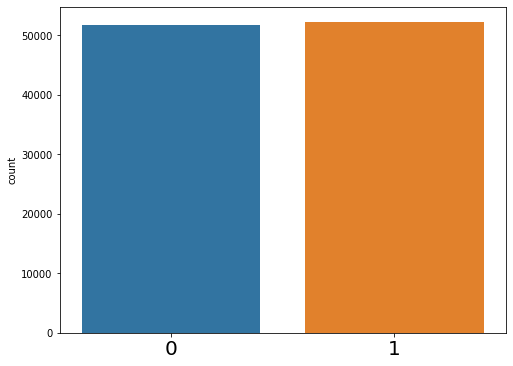

In [34]:
fig=plt.figure(figsize=(8,6))
sns.countplot(y_train)
plt.xticks(fontsize=20)
plt.show()
#fig.savefig('original_distribution.png', dpi=fig.dpi)

In [35]:
from sklearn.impute import SimpleImputer

X_train_data=SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train_data)
X_test_data=SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_test_data)

Random_Forest accuray is 0.930248678624036


KeyboardInterrupt: 

In [36]:
from sklearn import metrics

In [46]:
y_pred_rf=np.zeros(shape=(len(y_test),1))
y_pred_svc=np.zeros(shape=(len(y_test),1))
y_pred_nb=np.zeros(shape=(len(y_test),1))

def train_clf(name, clf, y_pred, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    acc=accuracy_score(y_test, y_pred) 

    y_pred_proba = clf.predict_proba(x_test)
    auc=roc_auc_score(y_test, y_pred_proba[:,1])

    
    print("{} accuracy is {}".format(name, acc))
    print("{} AUC is {}".format(name, auc))
    
train_clf('Random_Forest', RandomForestClassifier(), y_pred_rf,X_train_data,y_train,X_test_data,y_test)
train_clf('SVC',SVC(gamma='auto',probability=True), y_pred_svc,X_train_data,y_train,X_test_data,y_test)
train_clf('Naive bayes',GaussianNB(), y_pred_nb,X_train_data,y_train,X_test_data,y_test)

Random_Forest accuracy is 0.9285157265401611
Random_Forest AUC is 0.9720607574743327
SVC accuracy is 0.9289489645611299
SVC AUC is 0.970989276025886
Naive bayes accuracy is 0.8323368858851052
Naive bayes AUC is 0.9111055702860418


In [ ]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output

In [ ]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [ ]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

In [ ]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [242]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Min. Sentence # words:",min_len_sentences)

Min. Sentence # words: 100


In [ ]:
embed_size = np.size(corpora_train[0][0])

### Designing Baseline Architecture

In [244]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [246]:
gram_input = Input(shape = input_sh)
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

TensorShape([None, 94, 1, 32])

In [247]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([None, 1, 1, 32])

In [248]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([None, 32])

In [249]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([None, 32, 1, 1])

In [250]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([None, 28, 1, 64])

In [251]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([None, 1, 1, 64])

In [252]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([None, 64])

In [253]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([None, 64, 1, 1])

In [254]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([None, 62, 1, 128])

In [255]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([None, 60, 1, 128])

In [256]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([None, 58, 1, 64])

In [257]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([None, 1, 1, 64])

In [258]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([None, 64])

In [259]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]
deep_dense_1_layer.shape

TensorShape([None, 32])

In [260]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]
deep_dense_2_layer.shape

TensorShape([None, 32])

In [261]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]
deep_dense_3_layer.shape

TensorShape([None, 16])

In [385]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [386]:
print(criticality_network.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 1, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 94, 1, 32)         256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0   

In [388]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

### Training the criticality network

In [360]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [ ]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'test_x.dat')

In [362]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'test_x.dat')

In [363]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [364]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [365]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [366]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [369]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [370]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [371]:
#CheckPoints
filepath = "best_model.hdf5"

In [372]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [ ]:
length = len(corpora_train_x)
mask = np.random.choice(length, length, replace=False)
# Use the same mask to maintain the shuffling sequence between data and labels
shuffled_data = corpora_train_x[mask]
shuffled_labels = target_train_y[mask]


In [ ]:
#Model Fitting
history = criticality_network.fit(
            x = shuffled_data, 
            y = shuffled_labels,
            batch_size=64,
            epochs=40, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list,
            shuffle=True
)

In [ ]:
count_1 = 0
count_2 = 0
for i in target_train_y:
    if i[0] == 1:
        count_1 +=1 
    else:
        count_2 +=1
print('{}, {}'.format(count_1, count_2))

In [ ]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('history_training.csv', encoding='utf-8',index=False)

In [403]:
criticality_network.save(filepath)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693379,0.499856,0.693123,0.504933
1,0.693190,0.501420,0.693196,0.495067


In [404]:
#Saving Test Data
np.save('corpora_test_x.npy',corpora_test_x)
np.save('target_test_y.npy',target_test_y)

### Partial Evaluation
To make a deep evaluation, please refer to the "evaluation" notebook.

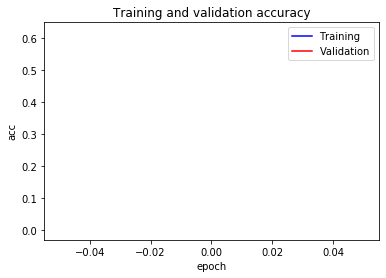

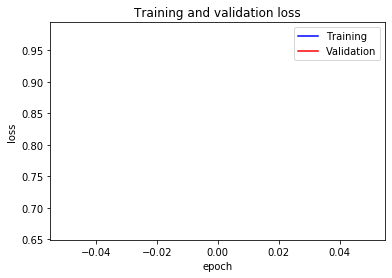

In [380]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()